### Fantasy Fumball: Using Machine Learning to Predict the Rank of Offensive Players in the NFL for Fantasy Football Drafting  

#### Introduction
Fantasy Sports is an industry estimated at over $7B per year (https://qz.com/1068534/how-the-7-billion-us-fantasy-football-industry-makes-its-money-in-2017/). It spans a host of sports and has spawned leagues and even a TV show (The League https://en.wikipedia.org/wiki/The_League) revolving around the players. My project specifically focused on fantasy football and selecting (aka drafting) the players that would be most likely to create a winning team. I set out to discover if it was possible to predict the rank of offensive players in the NFL for fantasy sports based on their statistics across the entire season.  

The objective of my project is to come up with a way to rank players so I can increase my probability of picking great starters and finally win my league.  

#### Fantasy Football Drafting and Assumptions  
Fantasy football is rife with stats for a data scientist. Most aspects of the game are quantified in discrete terms. Additionally, player rank is a continuous variable that we can test for and predict. I opted to only study offensive players that played positions that could be drafted onto my fantasy team. In this case, that meant evaluating the following positions: Quarterback (QB), Running back (RB), Wide Receiver (WR), Tight End (TE), and Kicker (K).  

Fantasy Football teams are comprised of players from all teams in the NFL. Players in the following positions may be drafted: Quarterback (QB), Running back (RB), Wide Receiver (WR), Tight End (TE), and Kicker (K). Each player may only be drafted onto one fantasy team per league. Each player in the league drafts one fantasy player for their team in rounds until the fantasy teams are filled.  

As a note, due to time constraints, I opted to ignore defensive positions for this project. The data I pulled was for individual players and we typically draft an entire team defense. I also ignored Points-Per-Reception (PPR) scoring in my calculations since my league does not play by that rule. Future work would also include an option to toggle PPR on or off as it can make a difference in drafting.

#### Data Collection and Preparation 
My data is pulled from https://github.com/BurntSushi/nflgame, an API to read and retrieve NFL Game Center JSON Data. I will be using 2016 full season stats for my feature set. I also pulled the top 300 player rank, as ranked by ESPN, for my response vector. 

In [2]:
# read the data into a DataFrame named nfl16
import pandas as pd
path = '../GA_Class_Project/'
url = path + 'season2016_wy.csv'
nfl16 = pd.read_csv(url, index_col = 0)
nfl16.head()

,id,home,team,pos,defense_ast,defense_ffum,defense_int,defense_sk,defense_tkl,fumbles_lost,...,receiving_twopta,receiving_twoptm,receiving_yds,rushing_att,rushing_lng,rushing_lngtd,rushing_tds,rushing_twopta,rushing_twoptm,rushing_yds
name,,,,,,,,,,,,,,,,,,,,,
T.Siemian,00-0032156,no,DEN,QB,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,28.0,42.0,0.0,0.0,1.0,0.0,57.0
A.Janovich,00-0032956,no,DEN,FB,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,44.0,4.0,33.0,28.0,1.0,0.0,0.0,33.0
D.Booker,00-0032972,no,DEN,RB,NaN,NaN,NaN,NaN,NaN,3.0,...,0.0,0.0,265.0,174.0,152.0,21.0,4.0,0.0,0.0,612.0
C.Anderson,00-0029854,no,DEN,RB,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,128.0,110.0,106.0,13.0,4.0,0.0,0.0,437.0
V.Green,00-0028142,no,DEN,TE,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,237.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Determine total number of players in dataframe
nfl16.shape
# 1573 players in this list with 59 attributes

(1573, 59)

In [4]:
# Determine how many players would be eligible to be drafted based on open positions in a fantasy roster
nfl16.pos.value_counts()

WR     205
RB     146
DE     144
CB     129
TE     115
OLB     93
DT      90
DB      79
QB      71
LB      66
SS      52
ILB     44
FS      43
K       35
P       35
NT      25
OT      19
FB      18
MLB     16
C       16
OG      12
T        7
G        7
LS       6
SAF      3
Name: pos, dtype: int64

Since I was only interested in QB, RB, WR, TE, K, I created new DataFrames using only these positions. This step was not totally necessary but it did simplify my data nicely.

In [5]:
# Create new DataFrames using only QB, WR, RB, TE, K
nfl16_QB = nfl16.loc[nfl16.pos == 'QB']
nfl16_WR = nfl16.loc[nfl16.pos == 'WR']
nfl16_RB = nfl16.loc[nfl16.pos == 'RB']
nfl16_TE = nfl16.loc[nfl16.pos == 'TE']
nfl16_K = nfl16.loc[nfl16.pos == 'K']

In [6]:
# Concat the new DataFrames back together as "nfl16_off"
frames = [nfl16_QB, nfl16_WR, nfl16_RB, nfl16_TE, nfl16_K]
nfl16_off = pd.concat(frames)
nfl16_off.shape

(572, 59)

In [7]:
# Perform a Sanity Check to make sure the expected players are still there
nfl16_off.head()

,id,home,team,pos,defense_ast,defense_ffum,defense_int,defense_sk,defense_tkl,fumbles_lost,...,receiving_twopta,receiving_twoptm,receiving_yds,rushing_att,rushing_lng,rushing_lngtd,rushing_tds,rushing_twopta,rushing_twoptm,rushing_yds
name,,,,,,,,,,,,,,,,,,,,,
T.Siemian,00-0032156,no,DEN,QB,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,28.0,42.0,0.0,0.0,1.0,0.0,57.0
C.Newton,00-0027939,no,CAR,QB,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,90.0,162.0,14.0,5.0,1.0,1.0,359.0
M.Ryan,00-0026143,no,ATL,QB,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,35.0,94.0,0.0,0.0,1.0,0.0,117.0
J.Winston,00-0031503,no,TB,QB,NaN,NaN,NaN,NaN,NaN,6.0,...,NaN,NaN,NaN,52.0,121.0,7.0,1.0,1.0,0.0,168.0
J.Flacco,00-0026158,no,BAL,QB,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,22.0,55.0,8.0,2.0,0.0,0.0,53.0


#### Fantasy Football Scoring
Players earn points based on their stats. The goal of your draft is to amass the highest scoring players on to your team. A breakdown point totals is below (https://fantasydata.com/resources/fantasy-scoring-system.aspx):  

Offensive Players  
•	Passing Yards: 1 point per 25 yards 
•	Passing Touchdowns: 4 points  
•	Passing Interceptions: -2 points  
•	Rushing Yards: 1 point per 10 yards  
•	Rushing Touchdowns: 6 points  
•	Receptions: 1 points (only if using PPR scoring)  
•	Receiving Yards: 1 point per 10 yards  
•	Receiving Touchdowns: 6 points  
•	2-Point Conversions: 2 points  
•	Fumbles Lost: -2 points  
•	Fumble Recovered for a Touchdown: 6 points  

Kicking  
•	Point After Touchdown (PAT) Made: 1 point  
•	Field Goal (FG) Made (0-49 yards): 3 points  
•	FG Made (50+ yards): 5 points  

I used the above listed point values and mapped them to each player's statistics to come up with the total number of points a player would have scored across the season. Of note, a kicker's statistics are more single game specific than other player's statistics. For example, a long range field goal (50+ yards) earns an extra 2 points for the kicker. Since I pulled full season data, I did not have the yardage breakdown in an easy to determine format. Future work would include looping through kickers stats for each game to give them their proper bonus points. For now, I assumed all Field Goals made were worth 3 points.

In [8]:
# Determine column headers
nfl16_off.columns.values.tolist()

['id',
 'home',
 'team',
 'pos',
 'defense_ast',
 'defense_ffum',
 'defense_int',
 'defense_sk',
 'defense_tkl',
 'fumbles_lost',
 'fumbles_rcv',
 'fumbles_tot',
 'fumbles_trcv',
 'fumbles_yds',
 'kicking_fga',
 'kicking_fgm',
 'kicking_fgyds',
 'kicking_totpfg',
 'kicking_xpa',
 'kicking_xpb',
 'kicking_xpmade',
 'kicking_xpmissed',
 'kicking_xptot',
 'kickret_avg',
 'kickret_lng',
 'kickret_lngtd',
 'kickret_ret',
 'kickret_tds',
 'passing_att',
 'passing_cmp',
 'passing_ints',
 'passing_tds',
 'passing_twopta',
 'passing_twoptm',
 'passing_yds',
 'punting_avg',
 'punting_i20',
 'punting_lng',
 'punting_pts',
 'punting_yds',
 'puntret_avg',
 'puntret_lng',
 'puntret_lngtd',
 'puntret_ret',
 'puntret_tds',
 'receiving_lng',
 'receiving_lngtd',
 'receiving_rec',
 'receiving_tds',
 'receiving_twopta',
 'receiving_twoptm',
 'receiving_yds',
 'rushing_att',
 'rushing_lng',
 'rushing_lngtd',
 'rushing_tds',
 'rushing_twopta',
 'rushing_twoptm',
 'rushing_yds']

In [9]:
# Map player stats to points using list comprehensions
fumbles_lost_pts = [x * -2 for x in nfl16_off.fumbles_lost]
passing_yds_pts = [x / 25 for x in nfl16_off.passing_yds]
passing_tds_pts = [x * 4 for x in nfl16_off.passing_tds]
passing_ints_pts = [x * -2 for x in nfl16_off.passing_ints]
rushing_yds_pts = [x / 10 for x in nfl16_off.rushing_yds]
rushing_tds_pts = [x * 6 for x in nfl16_off.rushing_tds]
receiving_yds_pts = [x / 10 for x in nfl16_off.receiving_yds]
receiving_tds_pts = [x * 6 for x in nfl16_off.receiving_tds]
passing_twoptm_pts = [x * 2 for x in nfl16_off.passing_twoptm]
receiving_twoptm_pts = [x * 2 for x in nfl16_off.receiving_twoptm]
rushing_twoptm_pts = [x * 2 for x in nfl16_off.rushing_twoptm]
kicking_xpmade_pts = [x * 1 for x in nfl16_off.kicking_xpmade]
# For now, counting all field goals as 3 points for ease of data
# fgyds doesn't work across entire season
kicking_fgm_pts = [x * 3 for x in nfl16_off.kicking_fgm]

In [10]:
# create DataFrame for list of pts, give it the same index as before
nflpts = pd.DataFrame(list(zip(fumbles_lost_pts, passing_yds_pts, passing_tds_pts, passing_ints_pts, rushing_yds_pts, rushing_tds_pts, receiving_yds_pts, receiving_tds_pts, passing_twoptm_pts, receiving_twoptm_pts, rushing_twoptm_pts, kicking_xpmade_pts, kicking_fgm_pts)),
                      index = nfl16_off.index,
                      columns=['fumbles_lost_pts', 'passing_yds_pts', 'passing_tds_pts', 'passing_ints_pts', 'rushing_yds_pts', 'rushing_tds_pts', 'receiving_yds_pts', 'receiving_tds_pts', 'passing_twoptm_pts', 'receiving_twoptm_pts', 'rushing_twoptm_pts', 'kicking_xpmade_pts', 'kicking_fgm_pts'])

type(nflpts)

pandas.core.frame.DataFrame

In [11]:
nflpts.head()

,fumbles_lost_pts,passing_yds_pts,passing_tds_pts,passing_ints_pts,rushing_yds_pts,rushing_tds_pts,receiving_yds_pts,receiving_tds_pts,passing_twoptm_pts,receiving_twoptm_pts,rushing_twoptm_pts,kicking_xpmade_pts,kicking_fgm_pts
name,,,,,,,,,,,,,
T.Siemian,-4.0,136.08,72.0,-20.0,5.7,0.0,NaN,NaN,2.0,NaN,0.0,NaN,NaN
C.Newton,-4.0,140.36,76.0,-28.0,35.9,30.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN
M.Ryan,-4.0,197.76,152.0,-14.0,11.7,0.0,NaN,NaN,2.0,NaN,0.0,NaN,NaN
J.Winston,-12.0,163.60,112.0,-36.0,16.8,6.0,NaN,NaN,6.0,NaN,0.0,NaN,NaN
J.Flacco,-6.0,172.68,80.0,-30.0,5.3,12.0,NaN,NaN,8.0,NaN,0.0,NaN,NaN


In [12]:
# Defining function to sum total points using for loop
def point_totals():
    tot_pts = []
    for index, row in nflpts.iterrows():
        tot_pts.append((index, row.sum()))
    return tot_pts
        
point_totals()[0:5]

[('T.Siemian', 191.78),
 ('C.Newton', 254.26000000000002),
 ('M.Ryan', 345.46),
 ('J.Winston', 256.40000000000003),
 ('J.Flacco', 241.98000000000002)]

In [13]:
# summing total points as list comprehension
# totalpoints = [(index, row.sum()) for index, row in nflpts.iterrows()] #this will return a tuple
totalpoints = [row.sum() for index, row in nflpts.iterrows()]
totalpoints

[191.78,
 254.26000000000002,
 345.46,
 256.40000000000003,
 241.98000000000002,
 270.92,
 169.42000000000002,
 46.76,
 270.2,
 380.02,
 223.78000000000003,
 259.3,
 332.32,
 268.32,
 133.36,
 260.64,
 212.98,
 260.74,
 266.05999999999995,
 190.28,
 286.88,
 224.18000000000004,
 66.44,
 307.70000000000005,
 279.98,
 244.66,
 35.059999999999995,
 300.76,
 252.16,
 72.7,
 111.14,
 7.44,
 9.38,
 52.1,
 15.66,
 5.16,
 28.3,
 9.379999999999999,
 -0.1,
 220.88000000000002,
 79.1,
 16.520000000000003,
 77.0,
 7.9,
 0.3,
 28.38,
 33.92,
 10.18,
 258.56,
 7.9399999999999995,
 70.84,
 16.66,
 28.0,
 9.0,
 0.44,
 -1.56,
 -0.4799999999999998,
 32.26,
 -1.5199999999999998,
 -0.2,
 53.160000000000004,
 8.940000000000001,
 1.7,
 200.07999999999998,
 54.74,
 17.64,
 0.64,
 0.88,
 1.7399999999999998,
 6.0,
 -1.44,
 133.60000000000002,
 136.3,
 23.3,
 105.0,
 134.1,
 32.2,
 63.1,
 44.3,
 176.9,
 89.8,
 0.0,
 78.0,
 47.0,
 208.1,
 17.3,
 130.8,
 6.5,
 113.9,
 68.1,
 38.8,
 -2.0,
 67.9,
 55.0,
 16.5,
 15.

In [14]:
nfl16_off.index

Index([u'T.Siemian', u'C.Newton', u'M.Ryan', u'J.Winston', u'J.Flacco',
       u'T.Taylor', u'B.Osweiler', u'J.Cutler', u'B.Bortles', u'A.Rodgers',
       ...
       u'C.Catanzaro', u'S.Gostkowski', u'D.Hopkins', u'C.Boswell',
       u'P.Dawson', u'G.Zuerlein', u'C.Parkey', u'J.Brown', u'R.Gould',
       u'K.Forbath'],
      dtype='object', name=u'name', length=572)

In [15]:
nflpts.describe()

,fumbles_lost_pts,passing_yds_pts,passing_tds_pts,passing_ints_pts,rushing_yds_pts,rushing_tds_pts,receiving_yds_pts,receiving_tds_pts,passing_twoptm_pts,receiving_twoptm_pts,rushing_twoptm_pts,kicking_xpmade_pts,kicking_fgm_pts
count,252.000000,89.000000,89.000000,89.000000,297.000000,297.000000,447.000000,447.000000,89.000000,447.000000,297.000000,35.000000,35.000000
mean,-2.111111,58.773034,35.280899,-9.325843,18.584175,8.727273,28.990828,10.442953,0.808989,0.134228,0.094276,31.885714,72.771429
std,2.379267,70.275743,45.708809,11.500766,30.075698,16.680109,32.322706,13.941284,1.776593,0.568111,0.484072,11.485980,23.264573
min,-12.000000,0.000000,0.000000,-42.000000,-1.200000,0.000000,-1.600000,0.000000,0.000000,0.000000,0.000000,9.000000,24.000000
25%,-2.000000,0.880000,0.000000,-16.000000,0.700000,0.000000,4.600000,0.000000,0.000000,0.000000,0.000000,23.500000,57.000000
50%,-2.000000,18.120000,8.000000,-4.000000,4.400000,0.000000,15.400000,6.000000,0.000000,0.000000,0.000000,32.000000,78.000000
75%,-0.000000,137.040000,72.000000,-0.000000,20.900000,12.000000,42.850000,18.000000,2.000000,0.000000,0.000000,40.500000,88.500000
max,-0.000000,208.320000,160.000000,-0.000000,163.100000,108.000000,144.800000,84.000000,10.000000,4.000000,4.000000,56.000000,114.000000


#### Adding Response Vector to Features
The nflgame API only included player stats but not player rank. I retrieved a Top 300 Fantasy Football player list from ESPN's website and appended it here.

In [16]:
url = path + 'rank2016_wy.csv'
nflrank = pd.read_csv(url, index_col = 'name')
nflrank.pos.value_counts()

WR     103
RB      91
TE      34
QB      32
DST     22
K       18
Name: pos, dtype: int64

In [17]:
# I dropped position from nflrank since it was already encoded in my original data
nflrank = nflrank.drop('pos', 1)
nflrank.head()

,rank
name,
A.Brown,1
O.Beckham,2
A.Peterson,3
J.Jones,4
T.Gurley,5


In [18]:
print nfl16_off.shape
print nflrank.shape
print nflpts.shape

(572, 59)
(300, 1)
(572, 13)


In [19]:
# add totalpoints to nflpts DataFrame
type(totalpoints)
# totalpoints is a list

totalpointslist = pd.Series(totalpoints)
nflpts['totalpoints'] = totalpointslist.values
nflpts.head()

,fumbles_lost_pts,passing_yds_pts,passing_tds_pts,passing_ints_pts,rushing_yds_pts,rushing_tds_pts,receiving_yds_pts,receiving_tds_pts,passing_twoptm_pts,receiving_twoptm_pts,rushing_twoptm_pts,kicking_xpmade_pts,kicking_fgm_pts,totalpoints
name,,,,,,,,,,,,,,
T.Siemian,-4.0,136.08,72.0,-20.0,5.7,0.0,NaN,NaN,2.0,NaN,0.0,NaN,NaN,191.78
C.Newton,-4.0,140.36,76.0,-28.0,35.9,30.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN,254.26
M.Ryan,-4.0,197.76,152.0,-14.0,11.7,0.0,NaN,NaN,2.0,NaN,0.0,NaN,NaN,345.46
J.Winston,-12.0,163.60,112.0,-36.0,16.8,6.0,NaN,NaN,6.0,NaN,0.0,NaN,NaN,256.40
J.Flacco,-6.0,172.68,80.0,-30.0,5.3,12.0,NaN,NaN,8.0,NaN,0.0,NaN,NaN,241.98


In [20]:
# Add nflrank to nflpts
# Since my original data has more rows than the player ranks, I had to join the DataFrames rather than concatenate them.
nfl = nflpts.join(nflrank)
nfl.head()

,fumbles_lost_pts,passing_yds_pts,passing_tds_pts,passing_ints_pts,rushing_yds_pts,rushing_tds_pts,receiving_yds_pts,receiving_tds_pts,passing_twoptm_pts,receiving_twoptm_pts,rushing_twoptm_pts,kicking_xpmade_pts,kicking_fgm_pts,totalpoints,rank
name,,,,,,,,,,,,,,,
A.Abdullah,NaN,NaN,NaN,NaN,10.1,0.0,5.7,6.0,NaN,0.0,0.0,NaN,NaN,21.8,75.0
A.Benn,NaN,NaN,NaN,NaN,NaN,NaN,11.6,6.0,NaN,0.0,NaN,NaN,NaN,17.6,NaN
A.Blue,-2.0,NaN,NaN,NaN,41.6,6.0,4.0,0.0,NaN,0.0,0.0,NaN,NaN,49.6,277.0
A.Boldin,NaN,NaN,NaN,NaN,NaN,NaN,58.4,48.0,NaN,0.0,NaN,NaN,NaN,106.4,183.0
A.Brown,NaN,NaN,NaN,NaN,0.9,0.0,128.4,72.0,NaN,0.0,0.0,NaN,NaN,201.3,1.0


In [21]:
nfl.shape

(582, 15)

In [22]:
nfl.describe()

,fumbles_lost_pts,passing_yds_pts,passing_tds_pts,passing_ints_pts,rushing_yds_pts,rushing_tds_pts,receiving_yds_pts,receiving_tds_pts,passing_twoptm_pts,receiving_twoptm_pts,rushing_twoptm_pts,kicking_xpmade_pts,kicking_fgm_pts,totalpoints,rank
count,259.000000,90.000000,90.000000,90.000000,303.000000,303.000000,456.000000,456.000000,90.000000,456.000000,303.000000,35.000000,35.000000,582.000000,293.000000
mean,-2.123552,58.120000,34.888889,-9.222222,18.957426,8.990099,29.542982,10.657895,0.800000,0.135965,0.092409,31.885714,72.771429,64.631443,140.515358
std,2.365815,70.153902,45.603185,11.478145,30.470597,17.276000,32.678513,14.351523,1.768641,0.569500,0.479419,11.485980,23.264573,71.664962,87.525597
min,-12.000000,0.000000,0.000000,-42.000000,-1.200000,0.000000,-1.600000,0.000000,0.000000,0.000000,0.000000,9.000000,24.000000,-2.000000,1.000000
25%,-2.000000,0.820000,0.000000,-15.500000,0.700000,0.000000,4.750000,0.000000,0.000000,0.000000,0.000000,23.500000,57.000000,8.955000,63.000000
50%,-2.000000,17.260000,8.000000,-4.000000,5.000000,0.000000,15.750000,6.000000,0.000000,0.000000,0.000000,32.000000,78.000000,38.700000,132.000000
75%,-0.000000,136.800000,71.000000,-0.000000,23.300000,12.000000,44.325000,18.000000,1.500000,0.000000,0.000000,40.500000,88.500000,103.200000,217.000000
max,-0.000000,208.320000,160.000000,-0.000000,163.100000,108.000000,144.800000,84.000000,10.000000,4.000000,4.000000,56.000000,114.000000,380.020000,296.000000


In [23]:
# The data from the nflgame API contained many blank cells
# For example, some players may never fumble the ball; QBs rarely receive the ball
nfl.isnull().sum()

fumbles_lost_pts        323
passing_yds_pts         492
passing_tds_pts         492
passing_ints_pts        492
rushing_yds_pts         279
rushing_tds_pts         279
receiving_yds_pts       126
receiving_tds_pts       126
passing_twoptm_pts      492
receiving_twoptm_pts    126
rushing_twoptm_pts      279
kicking_xpmade_pts      547
kicking_fgm_pts         547
totalpoints               0
rank                    289
dtype: int64

In [24]:
nfl.columns.tolist()

['fumbles_lost_pts',
 'passing_yds_pts',
 'passing_tds_pts',
 'passing_ints_pts',
 'rushing_yds_pts',
 'rushing_tds_pts',
 'receiving_yds_pts',
 'receiving_tds_pts',
 'passing_twoptm_pts',
 'receiving_twoptm_pts',
 'rushing_twoptm_pts',
 'kicking_xpmade_pts',
 'kicking_fgm_pts',
 'totalpoints',
 'rank']

#### Exploratory Data Analysis
I started with basic statistics and visualization to see if any features immediately stood out.

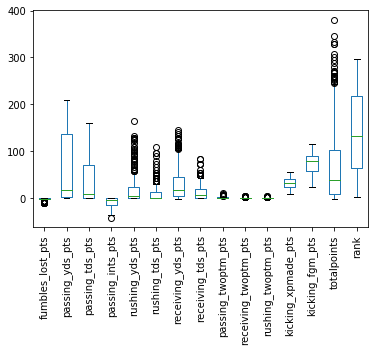

In [25]:
# Allow graphs to show in notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
nfl.plot(kind='box', rot = 90)
# Rank stands out at first because it's the most even.
# It seems like passing yards and passing touchdowns (tds) have big variance
# It looks like rushing yards, rushing tds, and receiving yards have the biggest outliers with fewer players running/catching the most
# Based on this chart, interceptions and two point conversions (twoptm) will likely have very little effect on player rank across the season

In [26]:
# Look for correlations between variables
nfl.corr()
# looks like rushing yards, rushing tds, receivings yards are the strongest correlated with rank but they're negative

,fumbles_lost_pts,passing_yds_pts,passing_tds_pts,passing_ints_pts,rushing_yds_pts,rushing_tds_pts,receiving_yds_pts,receiving_tds_pts,passing_twoptm_pts,receiving_twoptm_pts,rushing_twoptm_pts,kicking_xpmade_pts,kicking_fgm_pts,totalpoints,rank
fumbles_lost_pts,1.000000,-0.726639,-0.712538,0.656159,-0.117317,-0.165032,0.033827,-0.000555,-0.383717,-0.003519,-0.219874,NaN,NaN,-0.596127,0.055569
passing_yds_pts,-0.726639,1.000000,0.962518,-0.839883,0.112364,0.322765,-0.600154,-0.463194,0.530870,-0.196623,0.205928,NaN,NaN,0.859767,0.021639
passing_tds_pts,-0.712538,0.962518,1.000000,-0.777961,0.126481,0.277396,-0.586618,-0.435845,0.527140,-0.211255,0.203206,NaN,NaN,0.871378,-0.093374
passing_ints_pts,0.656159,-0.839883,-0.777961,1.000000,-0.039039,-0.193014,0.594430,0.442476,-0.431711,0.195117,-0.193691,NaN,NaN,-0.641777,-0.020254
rushing_yds_pts,-0.117317,0.112364,0.126481,-0.039039,1.000000,0.865657,-0.070950,-0.107187,0.030918,0.031828,0.265340,NaN,NaN,0.516001,-0.331435
rushing_tds_pts,-0.165032,0.322765,0.277396,-0.193014,0.865657,1.000000,-0.037074,-0.079323,0.106120,0.085520,0.239986,NaN,NaN,0.550623,-0.273760
receiving_yds_pts,0.033827,-0.600154,-0.586618,0.594430,-0.070950,-0.037074,1.000000,0.811358,-0.384883,0.387912,-0.061770,NaN,NaN,0.662311,-0.309339
receiving_tds_pts,-0.000555,-0.463194,-0.435845,0.442476,-0.107187,-0.079323,0.811358,1.000000,-0.296996,0.293431,0.022769,NaN,NaN,0.581790,-0.211896
passing_twoptm_pts,-0.383717,0.530870,0.527140,-0.431711,0.030918,0.106120,-0.384883,-0.296996,1.000000,-0.127302,0.069759,NaN,NaN,0.459297,0.002238
receiving_twoptm_pts,-0.003519,-0.196623,-0.211255,0.195117,0.031828,0.085520,0.387912,0.293431,-0.127302,1.000000,-0.040875,NaN,NaN,0.285989,-0.143427


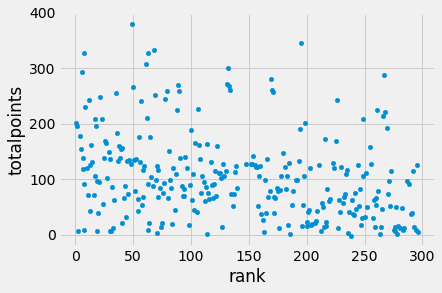

In [126]:
# Scatter plot total points v rank
nfl.plot.scatter('rank','totalpoints');

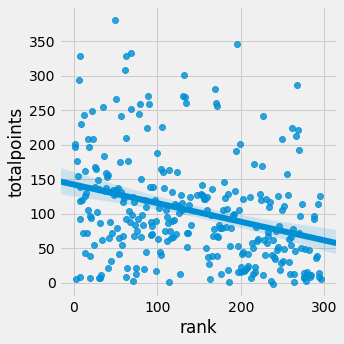

In [127]:
# Scatter Plot of total points v. rank with linear regression added
import seaborn as sns
sns.lmplot(x='rank',y='totalpoints',data=nfl,fit_reg=True); 
# totalpoints and rank are negatively correlated
# this makes sense since those that score high points will have a 'lower' rank
# for rank, lower is better

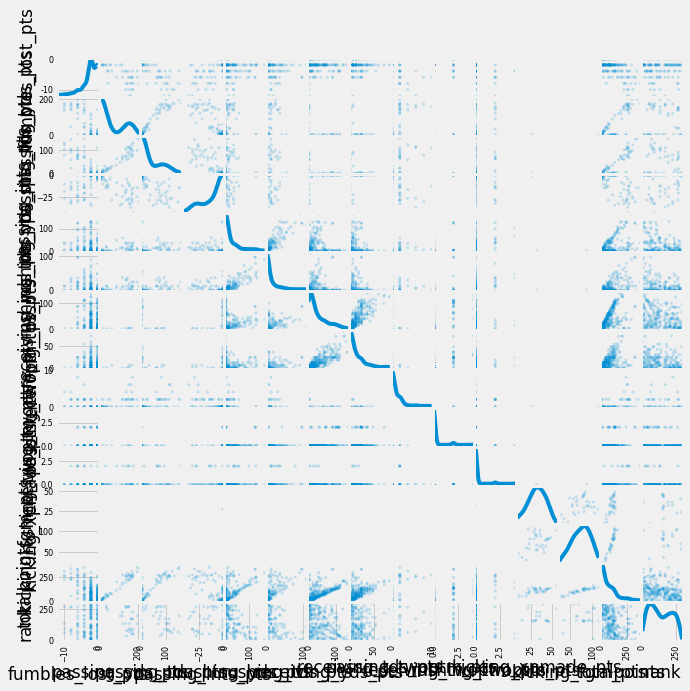

In [128]:
# Plot Everything as Scatter Matrix Instead
pd.plotting.scatter_matrix(nfl, alpha=0.2, figsize=(10, 10), diagonal='kde');

# This is a very tiny matrix, I can't tell anything

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000204B6CF8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000220D48D0>]], dtype=object)

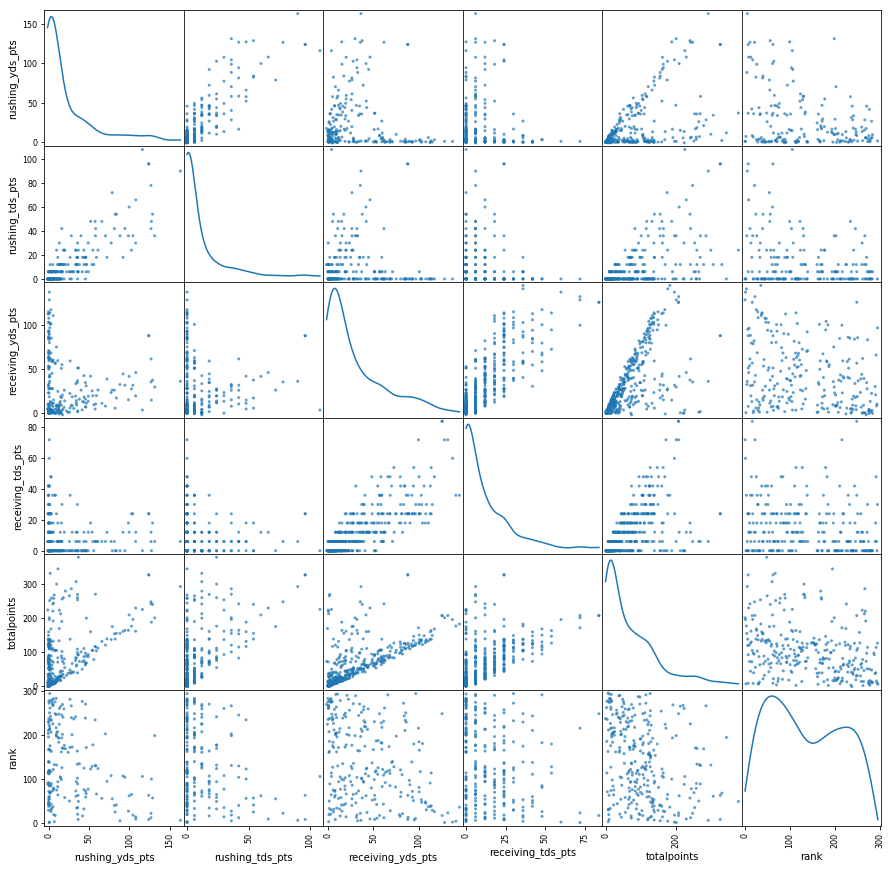

In [30]:
# Plot just the stronger correlated variables
pd.plotting.scatter_matrix(nfl[['rushing_yds_pts', 'rushing_tds_pts', 'receiving_yds_pts', 'receiving_tds_pts', 'totalpoints', 'rank']], alpha=0.7, figsize=(15, 15), diagonal='kde')
# Nothing appears to be correlated with rank directly
# But there are strong correlations between receiving yards/tds or rushing yards/tds
# This seems like an obvious conclusion since yardage at some point will hopefuly result in a touchdown

#### Project Modeling using Random Forest
I haven't learned much about rank yet using correlations so I moved on to modeling. I started with random forest to do a quick preliminary model that would also determine important features without having to do feature scaling.

In [31]:
# Need to fill in null values, not sure what to fill with
# Create DataFrame to fill null with column means
nflmean = nfl.copy()

# Create DataFrame to fill null with column medians
nflmedian = nfl.copy()

# Create DataFrame to fill null with zeros
nflzero = nfl.copy()

In [32]:
'''for column in dataframe:
    fill null with column mean/median/zero'''

skip_col = ['pos','rank']

for column in nflmean:
    if column not in skip_col:
        nflmean[column].fillna(nflmean[column].mean(), inplace = True)

for column in nflmedian:
    if column not in skip_col:
        nflmedian[column].fillna(nflmedian[column].median(), inplace = True)

for column in nflzero:
    if column not in skip_col:
        nflzero[column].fillna(0, inplace = True)


In [33]:
nflmean.head()
nflmean.isnull().sum()

fumbles_lost_pts          0
passing_yds_pts           0
passing_tds_pts           0
passing_ints_pts          0
rushing_yds_pts           0
rushing_tds_pts           0
receiving_yds_pts         0
receiving_tds_pts         0
passing_twoptm_pts        0
receiving_twoptm_pts      0
rushing_twoptm_pts        0
kicking_xpmade_pts        0
kicking_fgm_pts           0
totalpoints               0
rank                    289
dtype: int64

In [34]:
nflmedian.head()
nflmedian.isnull().sum()

fumbles_lost_pts          0
passing_yds_pts           0
passing_tds_pts           0
passing_ints_pts          0
rushing_yds_pts           0
rushing_tds_pts           0
receiving_yds_pts         0
receiving_tds_pts         0
passing_twoptm_pts        0
receiving_twoptm_pts      0
rushing_twoptm_pts        0
kicking_xpmade_pts        0
kicking_fgm_pts           0
totalpoints               0
rank                    289
dtype: int64

In [35]:
nflzero.head()
nflzero.isnull().sum()

fumbles_lost_pts          0
passing_yds_pts           0
passing_tds_pts           0
passing_ints_pts          0
rushing_yds_pts           0
rushing_tds_pts           0
receiving_yds_pts         0
receiving_tds_pts         0
passing_twoptm_pts        0
receiving_twoptm_pts      0
rushing_twoptm_pts        0
kicking_xpmade_pts        0
kicking_fgm_pts           0
totalpoints               0
rank                    289
dtype: int64

In [37]:
nfl.isnull().sum()

fumbles_lost_pts        323
passing_yds_pts         492
passing_tds_pts         492
passing_ints_pts        492
rushing_yds_pts         279
rushing_tds_pts         279
receiving_yds_pts       126
receiving_tds_pts       126
passing_twoptm_pts      492
receiving_twoptm_pts    126
rushing_twoptm_pts      279
kicking_xpmade_pts      547
kicking_fgm_pts         547
totalpoints               0
rank                    289
dtype: int64

In [39]:
# predicting rank with a Random Forest
# selecting and instantiating the estimator
import numpy as np
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor()
rfreg

# list of values to try for n_estimators
estimator_range = range(10, 310, 10)
# 10 estimators, up to 300, in steps of 10

# Need to drop nulls from dataframe first
nflmean.dropna(inplace = True)
nflmean.shape #(293, 15)
# Dropped to 293 rows from 582 because only pulled top 300 players by rank, some team defenses in the mix.

#define X and y
feature_cols = nflmean.columns.drop('rank')
feature_cols
X_mean = nflmean[feature_cols]
y_mean = nflmean['rank']

# list to store the average RMSE for each value of n_estimators
nflmean_RMSE_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
from sklearn.model_selection import cross_val_score
for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1)
    nflmean_MSE_scores = cross_val_score(rfreg, X_mean, y_mean, cv=5, scoring='neg_mean_squared_error')
    nflmean_RMSE_scores.append(np.mean(np.sqrt(-nflmean_MSE_scores)))

print nflmean_RMSE_scores

[82.730486848641107, 82.5743676567958, 82.791337323761752, 82.446465825532613, 82.002537339661373, 81.868247183144604, 81.993492076947817, 82.075964512671916, 81.872361642177594, 81.913880715960005, 82.072265256026299, 82.291578409638788, 82.419744544015231, 82.204689124941098, 82.190213255653319, 82.234433606732523, 82.351866001672136, 82.269644311790785, 82.274380852647994, 82.282082600552513, 82.407752748574183, 82.3985007079296, 82.398555309906655, 82.285407240912079, 82.206575628098904, 82.352251825267189, 82.434112653439044, 82.436282045452003, 82.463241534560524, 82.474103220759531]


In [ ]:
# write a loop to test cv values

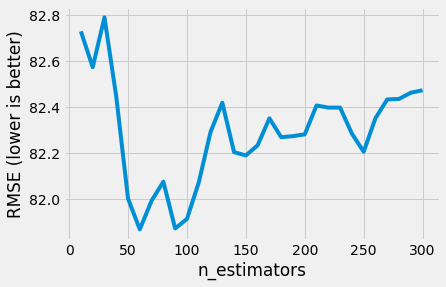

In [129]:
# plot n_estimators (x-axis) versus RMSE (y-axis)
plt.plot(estimator_range, nflmean_RMSE_scores);
plt.xlabel('n_estimators')
plt.ylabel('RMSE (lower is better)')
# somewhere bteween 50 and 100 estimators seems like low RMSE

In [47]:
# show the best RMSE and the corresponding n_estimators
sorted(zip(nflmean_RMSE_scores, estimator_range))[0]
# using n_estimators = 60 seems best

(81.868247183144604, 60)

In [42]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average RMSE for each value of max_features
nflmean_max_RMSE_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=60, max_features=feature, random_state=1)
    nflmean_max_MSE_scores = cross_val_score(rfreg, X_mean, y_mean, cv=10, scoring='neg_mean_squared_error')
    nflmean_max_RMSE_scores.append(np.mean(np.sqrt(-nflmean_max_MSE_scores)))
    
print nflmean_max_RMSE_scores

[83.169217327704217, 82.630143649207568, 82.491931057539517, 81.474576346211705, 81.833084810761648, 82.136572396568226, 82.17860172504146, 81.560543754474381, 81.573825283404204, 82.151389393029589, 81.170729160313442, 82.158834695557402, 81.091616460446033, 82.058768434163468]


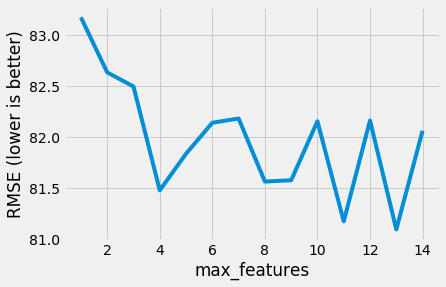

In [130]:
# plot max_features (x-axis) versus RMSE (y-axis)
plt.plot(feature_range, nflmean_max_RMSE_scores);
plt.xlabel('max_features')
plt.ylabel('RMSE (lower is better)')
# 13 features is best

In [45]:
# show the best RMSE and the corresponding max_features
sorted(zip(nflmean_max_RMSE_scores, feature_range))[0]
# using 13 features seems best

(81.091616460446033, 13)

In [48]:
# max_features=13 is best and n_estimators=60
rfreg = RandomForestRegressor(n_estimators=60, max_features=13, oob_score=True, random_state=1)
rfreg.fit(X_mean, y_mean)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=13, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=60, n_jobs=1, oob_score=True, random_state=1,
           verbose=0, warm_start=False)

In [50]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':rfreg.feature_importances_}).sort_values('importance', ascending=False)
# looks like totalpoints is most important which seems obvious since fantasy football is based on fantasy points
# next is receiving yards and to a lesser extent, rushing yards
# e.g. WRs and RBs which also seems obvious since they are responsible for a lot of movement on the field

,feature,importance
13,totalpoints,0.307617
6,receiving_yds_pts,0.257463
4,rushing_yds_pts,0.169146
7,receiving_tds_pts,0.086722
0,fumbles_lost_pts,0.039199
5,rushing_tds_pts,0.032189
2,passing_tds_pts,0.021820
12,kicking_fgm_pts,0.018654
11,kicking_xpmade_pts,0.018611
9,receiving_twoptm_pts,0.014018


#### Conclusions from Random Forest
Totalpoints appears to be the most important feature which seems obvious since fantasy football is based on fantasy points. The next most important features are receiving yards and rushing yards. These stats maps to WRs and RBs which also seems obvious since they are responsible for a lot of movement on the field.  
I next set out to visualize these important features.

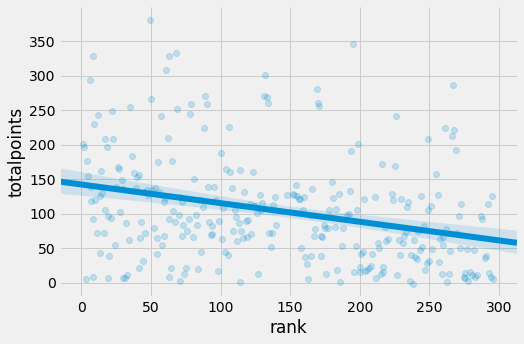

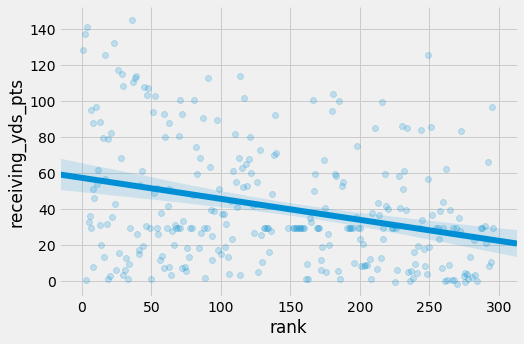

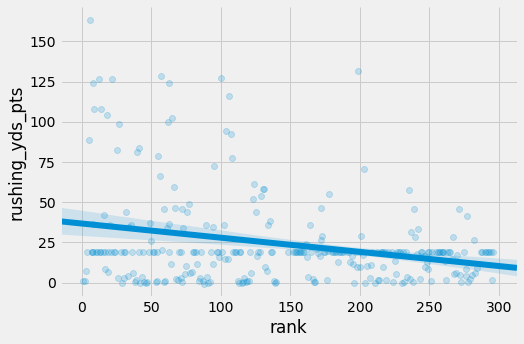

In [131]:
# starting with scatter plots and linreg lines for receiving and rushing yds
print sns.lmplot(x='rank', y='totalpoints', data=nflmean, aspect=1.5, scatter_kws={'alpha':0.2});
print sns.lmplot(x='rank', y='receiving_yds_pts', data=nflmean, aspect=1.5, scatter_kws={'alpha':0.2});
print sns.lmplot(x='rank', y='rushing_yds_pts', data=nflmean, aspect=1.5, scatter_kws={'alpha':0.2});
# all show negative correlation
# makes sense since low rank is good

#### Project Modeling using Linear Regression
Since there appears to be a linear pattern, I used linear regression to determine how much changing a variable (e.g. rushing yards) affects the outcome (rank).

In [155]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

# create a list of features
imp_feature_cols = ['totalpoints','rushing_yds_pts','receiving_yds_pts']
X_lin = nflmean[imp_feature_cols]
y_lin = nflmean['rank']

X_lin_tr, X_lin_te, y_lin_tr, y_lin_te = train_test_split(X_lin, y_lin, random_state=1)

In [157]:
# fit the model
linreg.fit(X_lin_tr, y_lin_tr)

# predict from model and determine error
y_lin_pred = linreg.predict(X_lin_te)
np.sqrt(metrics.mean_squared_error(y_lin_te, y_lin_pred))
# RMSE = 74.76

74.756242798704008

In [159]:
print linreg.intercept_
print linreg.coef_
zip(imp_feature_cols, linreg.coef_)

211.808173066
[-0.12615973 -0.94943358 -0.81969633]


[('totalpoints', -0.12615973386161361),
 ('rushing_yds_pts', -0.94943358138773681),
 ('receiving_yds_pts', -0.81969632808597337)]

In [160]:
# Compare to null RMSE

# create a NumPy array with the same shape as y_test
y_lin_null = np.zeros_like(y_lin_te, dtype=float)

# fill the array with the mean value of y_test
y_lin_null.fill(y_lin_te.mean())

# compute null RMSE
np.sqrt(metrics.mean_squared_error(y_lin_te, y_lin_null))
# RMSE = 80.80

# My model performs better than null!

80.800934947472513

#### Linear Regression Conclusions
Looking at the coefficients, a player would have to gain ~1 rushing or receiving yard point to improve their rank by 1. Based on the point mapping, that means they would have to gain at least 10 more yards to improve their rank. Similarly, with total points, players would have to gain ~8 points in order to improve their rank by 1.  
This information is helpful when looking at trends in a player's performance.

#### Future work
- See if I can predict improvement in players across years.  
- Split apart field goals into 3 and 5 points. For now, just scored all field goals made as 3 points since I did not want to loop through all kickers of each game across the entire season to determine which kicks were longer than others.
- For future work, I would like to aggregate players of a team's defense and pull a full team score across the season to further improve my rank predictions.
- Try to draft position rank besides positions (e.g. WR1, WR2)
- Turn this into a product with a user interface to select a player and determine their rank against other players. Unfortunately, while a good lesson, "who should I pick" already exists as a product.

In [154]:
# 2017 top 200 fantasy player rankings http://www.espn.com/fantasy/football/story/_/page/17RanksPreseason200nonPPR/2017-fantasy-football-standard-rankings-non-ppr-top-200
url = path + 'season2017.csv'
nfl17 = pd.read_csv(url, index_col = 0)
nfl17.head()
nfl17.loc[nfl17.index == 'T.Siemian']

,id,home,team,pos,defense_ast,defense_ffum,defense_int,defense_sk,defense_tkl,fumbles_lost,...,receiving_twopta,receiving_twoptm,receiving_yds,rushing_att,rushing_lng,rushing_lngtd,rushing_tds,rushing_twopta,rushing_twoptm,rushing_yds
name,,,,,,,,,,,,,,,,,,,,,
T.Siemian,00-0032156,no,DEN,QB,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,31.0,85.0,1.0,1.0,0.0,0.0,127.0
